# 上涨敲出看涨期权（Up-and-Out Call）蒙特卡洛定价

## 1. 蒙特卡洛定价（Black-Scholes模型下）- 上涨敲出看涨期权 (Up-and-Out Call)

### 解答：蒙特卡洛定价方法与实现步骤

对于**上涨敲出看涨期权 (Up-and-Out Call)**，其到期日现金流（Payoff）为：

$$
\Large
P_T = (S_T - K)^+ \cdot \mathbf{1}_{\{ \max_{0 \leq t \leq T} S_t < B \}}
$$

其中：
- $ S_t $：标的资产（Underlying Asset）在时间 $ t $ 的价格
- $ K $：执行价格（Strike Price）
- $ B $：障碍价格（Barrier Price），且满足 $ 0 < S_0 < B $
- $ T $：到期时间（Maturity）
- $ \mathbf{1}_{\{ \cdot \}} $：指示函数（Indicator Function），当条件满足时取值为1，否则为0

在风险中性定价测度（Risk-Neutral Pricing Measure）下，假设标的资产价格 $ S_t $ 遵循几何布朗运动（Geometric Brownian Motion, GBM），其随机微分方程（Stochastic Differential Equation, SDE）为：

$$
\Large
dS_t = r S_t dt + \sigma S_t dW_t
$$

其中：
- $ r $：无风险利率（Risk-Free Interest Rate），常数
- $ \sigma $：波动率（Volatility），常数
- $ W_t $：标准布朗运动（Standard Brownian Motion）

**蒙特卡洛模拟（Monte Carlo Simulation）定价步骤**：

1. **路径模拟（Path Simulation）**：使用欧拉离散化（Euler Discretization Scheme）在均匀时间网格上模拟 $ M $ 条标的资产价格路径。
   - 时间网格：$ 0 = t_0 < t_1 < \cdots < t_N = T $，步长 $ \Delta t = T/N $
   - 欧拉离散化格式：
     $$
     \Large
     S_{t_{n+1}} = S_{t_n} + r S_{t_n} \Delta t + \sigma S_{t_n} \sqrt{\Delta t} \, Z_n
     $$
     其中 $ Z_n \sim \mathcal{N}(0,1) $，独立同分布。

2. **计算每条路径的Payoff**：
   - 记录每条路径上的最大值 $ \max_{0 \leq t \leq T} S_t $
   - 若 $ \max_{0 \leq t \leq T} S_t < B $，则 Payoff = $ \max(S_T - K, 0) $；否则 Payoff = 0

3. **贴现与估计（Discounting and Estimation）**：
   - 将每条路径的 Payoff 以无风险利率贴现至初始时刻：$ P_0 = e^{-rT} \cdot \text{Payoff} $
   - 期权初始溢价（Premium）的蒙特卡洛估计：$ \hat{P}_0 = \frac{1}{M} \sum_{i=1}^M P_0^{(i)} $

4. **置信区间（Confidence Interval）**：
   - 计算样本标准差 $ s $
   - 对于大样本，$ 99\% $ 渐近置信区间为：
     $$
     \Large
     \hat{P}_0 \pm z_{0.995} \cdot \frac{s}{\sqrt{M}}, \quad z_{0.995} \approx 2.576
     $$


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [13]:
def simulate_gbm_paths_euler(S0, r, sigma, T, N, M):
    """
    使用欧拉离散化方法模拟几何布朗运动（GBM）的路径
    
    参数:
    S0: 初始资产价格
    r: 无风险利率
    sigma: 波动率
    T: 总时间长度（年）
    N: 时间步数
    M: 模拟的路径数量
    
    返回:
    t: 时间点数组，形状为 (N+1,)
    S: 资产价格路径矩阵，形状为 (N+1, M)
    """
    t = np.linspace(0, T, N + 1)
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    
    S = np.zeros((N + 1, M))
    S[0, :] = S0
    
    Z = norm.rvs(size = (N, M))
    
    for n in tqdm.tqdm(range(N), desc="Simulating GBM paths", unit="step"):
        S[n + 1, :] = S[n, :] * (1 + r * dt + sigma * sqrt_dt * Z[n, :])
        
    return t, S

In [14]:
def compute_up_and_out_call_payoff(S_path, K, B):
    """
    计算上涨敲出看涨期权的payoff
    
    参数:
    S_path: 资产价格路径矩阵，形状为 (N+1, M)
    K: 执行价格
    B: 障碍价格（需满足 S0 < B）
    
    返回:
    payoff: 每条路径的payoff，形状为 (M,)
    """
    M = S_path.shape[1]
    
    payoffs = np.zeros(M)
    for i in range(M):                      # 检查每条路径是否触碰障碍
        max_price = np.max(S_path[:, i])    # 路径上的最高价格
        final_price = S_path[-1, i]         # 到期价格
        
        if max_price < B:                   # 未触碰障碍
            payoffs[i] = max(final_price - K, 0)
        else:                               # 触碰障碍，期权失效
            payoffs[i] = 0
    
    # # 向量化
    # max_prices = np.max(S_path, axis = 0)
    # final_prices = S_path[-1, :]
    # payoffs = np.where(max_prices < B, np.maximum(final_prices - K, 0), 0)
    
    return payoffs

In [15]:
def price_up_and_out_call_monte_carlo(S0, K, B, T, r, sigma, M, N, confidence_level = 0.99):
    """
    使用蒙特卡洛方法定价上涨敲出看涨期权
    
    参数:
    S0: 初始资产价格
    K: 执行价格
    B: 障碍价格（需满足 S0 < B）重要！！！
    T: 到期时间（年）
    r: 无风险利率
    sigma: 波动率
    M: 蒙特卡洛模拟路径数
    N: 时间步数
    confidence_level: 置信水平（默认0.99）
    
    返回:
    dict: 包含价格估计、置信区间等信息的字典
    """
    # 1. 模拟GBM路径
    t, S_paths = simulate_gbm_paths_euler(S0, r, sigma, T, N, M)
    
    # 2. 计算每条路径的payoff
    payoffs = compute_up_and_out_call_payoff(S_paths, K, B)
    
    # 3. 贴现payoff
    discount_factor = np.exp(-r * T)
    discounted_payoffs = payoffs * discount_factor
    
    # 4. 计算统计量
    price_estimate = np.mean(discounted_payoffs)
    price_std = np.std(discounted_payoffs, ddof = 1)
    price_se = price_std / np.sqrt(M)
    
    # 5. 计算置信区间
    z_value = norm.ppf((1 + confidence_level) / 2)
    ci_half_width = z_value * price_se
    ci_lower = price_estimate - ci_half_width
    ci_upper = price_estimate + ci_half_width
    
    return {
        'price_estimate': price_estimate,
        'price_std': price_std,
        'price_se': price_se,
        'confidence_interval': (ci_lower, ci_upper),
        'confidence_level': confidence_level,
        'discounted_payoffs': discounted_payoffs,
        'paths': S_paths,
        'time_grid': t
    }


In [16]:
def plot_paths_with_barrier(t, paths, B, num_paths_to_plot = 50):
    """
    绘制GBM路径并标出障碍水平
    
    参数:
    t: 时间网格
    paths: GBM路径矩阵
    B: 障碍价格
    num_paths_to_plot: 要绘制的路径数量
    """
    M = paths.shape[1]
    num_paths = min(num_paths_to_plot, M)
    
    plt.figure(figsize=(12, 6))
    
    # 绘制路径
    for i in range(num_paths):
        max_price = np.max(paths[:, i])
        color = 'red' if max_price >= B else 'blue'
        alpha = 0.3 if max_price >= B else 0.1
        plt.plot(t, paths[:, i], color=color, alpha=alpha, linewidth=0.5)
    
    # 绘制障碍线
    plt.axhline(y=B, color='green', linestyle='--', linewidth=2, label=f'Barrier B = {B}')
    
    # 绘制执行价格线
    plt.axhline(y=paths[0, 0], color='black', linestyle=':', linewidth=1.5, label=f'Initial Price S0 = {paths[0, 0]}')
    
    plt.xlabel('Time (years)', fontsize=12)
    plt.ylabel('Asset Price', fontsize=12)
    plt.title(f'GBM Paths with Barrier (B={B}) - Red: Knocked Out, Blue: Active', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [17]:
def analyze_sensitivity_to_M(S0, K, B, T, r, sigma, N, M_list):
    """
    分析期权价格对蒙特卡洛模拟路径数M的敏感性
    
    参数:
    M_list: 模拟路径数的列表
    其他参数同 price_up_and_out_call_monte_carlo
    """
    price_estimates = []
    ci_lowers = []
    ci_uppers = []
    standard_errors = []
    
    for M in tqdm.tqdm(M_list, desc="Sensitivity to M"):
        results = price_up_and_out_call_monte_carlo(S0, K, B, T, r, sigma, M, N)
        price_estimates.append(results['price_estimate'])
        ci_lowers.append(results['confidence_interval'][0])
        ci_uppers.append(results['confidence_interval'][1])
        standard_errors.append(results['price_se'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 图1：价格和置信区间
    ax1.plot(M_list, price_estimates, 'b-', linewidth=2, label='Price Estimate')
    ax1.fill_between(M_list, ci_lowers, ci_uppers, alpha=0.2, color='blue', label='99% CI')
    ax1.set_xscale('log')
    ax1.set_xlabel('Number of Monte Carlo Simulations (M)', fontsize=12)
    ax1.set_ylabel('Option Premium', fontsize=12)
    ax1.set_title('Price Estimate vs. M (log scale)', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 图2：标准误差
    ax2.plot(M_list, standard_errors, 'r-', linewidth=2)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of Monte Carlo Simulations (M)', fontsize=12)
    ax2.set_ylabel('Standard Error (log scale)', fontsize=12)
    ax2.set_title('Standard Error vs. M', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'M_values': M_list,
        'price_estimates': price_estimates,
        'confidence_intervals': list(zip(ci_lowers, ci_uppers)),
        'standard_errors': standard_errors
    }


In [18]:
def analyze_sensitivity_to_N(S0, K, B, T, r, sigma, M, N_list):
    """
    分析期权价格对时间步数N的敏感性
    
    参数:
    N_list: 时间步数的列表
    其他参数同 price_up_and_out_call_monte_carlo
    """
    price_estimates = []
    
    for N in tqdm.tqdm(N_list, desc="Sensitivity to N"):
        results = price_up_and_out_call_monte_carlo(S0, K, B, T, r, sigma, M, N)
        price_estimates.append(results['price_estimate'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(N_list, price_estimates, 'g-o', linewidth=2, markersize=8)
    plt.xlabel('Number of Time Steps (N)', fontsize=12)
    plt.ylabel('Option Premium', fontsize=12)
    plt.title(f'Sensitivity to Discretization (M={M})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'N_values': N_list,
        'price_estimates': price_estimates
    }

In [19]:
def run_comprehensive_analysis():
    """
    运行综合测试分析
    """
    # 基础参数设置（与项目要求一致）
    S0 = 100
    K = 100
    B = 120  # 障碍价格（S0 < B）
    T = 1.0
    r = 0.05
    sigma = 0.20
    
    print("=" * 60)
    print("UP-AND-OUT CALL OPTION - MONTE CARLO PRICING ANALYSIS")
    print("=" * 60)
    print(f"Parameters: S0={S0}, K={K}, B={B}, T={T}, r={r}, σ={sigma}")
    print()
    
    # 1. 单次定价示例
    print("1. Single Pricing Example:")
    print("-" * 40)
    
    M = 10000
    N = 252  # 假设交易日数
    
    results = price_up_and_out_call_monte_carlo(S0, K, B, T, r, sigma, M, N)
    
    print(f"   Monte Carlo Paths: M = {M}")
    print(f"   Time Steps: N = {N}")
    print(f"   Price Estimate: {results['price_estimate']:.4f}")
    print(f"   Standard Error: {results['price_se']:.6f}")
    print(f"   {int(results['confidence_level']*100)}% Confidence Interval: [{results['confidence_interval'][0]:.4f}, {results['confidence_interval'][1]:.4f}]")
    print()
    
    # 2. 绘制路径示例
    print("2. Visualizing Sample Paths:")
    print("-" * 40)
    
    # 用小M快速生成路径用于可视化
    t, sample_paths = simulate_gbm_paths_euler(S0, r, sigma, T, 100, 200)
    plot_paths_with_barrier(t, sample_paths, B, num_paths_to_plot=100)
    
    # 3. 对M的敏感性分析
    print("3. Sensitivity Analysis to M (Number of Simulations):")
    print("-" * 40)
    
    M_list = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
    M_sensitivity = analyze_sensitivity_to_M(S0, K, B, T, r, sigma, N, M_list)
    
    # 4. 对N的敏感性分析
    print("4. Sensitivity Analysis to N (Number of Time Steps):")
    print("-" * 40)
    
    N_list = [10, 25, 50, 100, 252, 500, 1000]
    N_sensitivity = analyze_sensitivity_to_N(S0, K, B, T, r, sigma, M, N_list)
    
    print()
    print("=" * 60)
    print("ANALYSIS COMPLETE")
    print("=" * 60)
    
    return {
        'single_pricing': results,
        'M_sensitivity': M_sensitivity,
        'N_sensitivity': N_sensitivity,
    }

UP-AND-OUT CALL OPTION - MONTE CARLO PRICING ANALYSIS
Parameters: S0=100, K=100, B=120, T=1.0, r=0.05, σ=0.2

1. Single Pricing Example:
----------------------------------------


Simulating GBM paths: 100%|██████████| 252/252 [00:00<00:00, 31505.10step/s]


   Monte Carlo Paths: M = 10000
   Time Steps: N = 252
   Price Estimate: 1.3482
   Standard Error: 0.034142
   99% Confidence Interval: [1.2603, 1.4361]

2. Visualizing Sample Paths:
----------------------------------------


Simulating GBM paths: 100%|██████████| 100/100 [00:00<?, ?step/s]


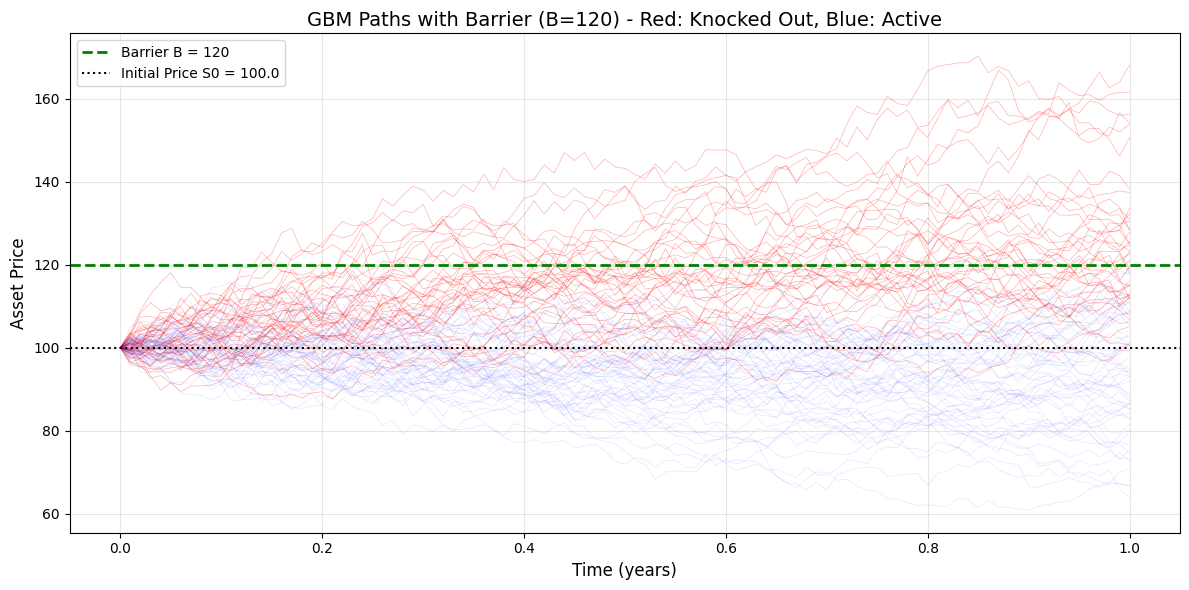

3. Sensitivity Analysis to M (Number of Simulations):
----------------------------------------


Sensitivity to M: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s]


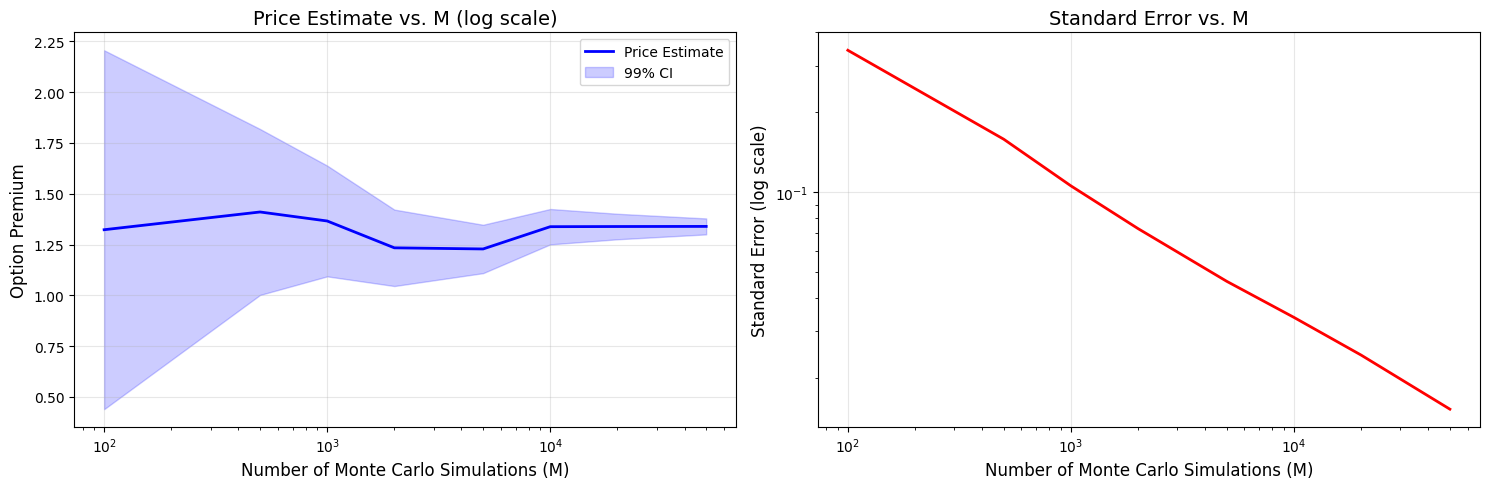

4. Sensitivity Analysis to N (Number of Time Steps):
----------------------------------------


Sensitivity to N: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


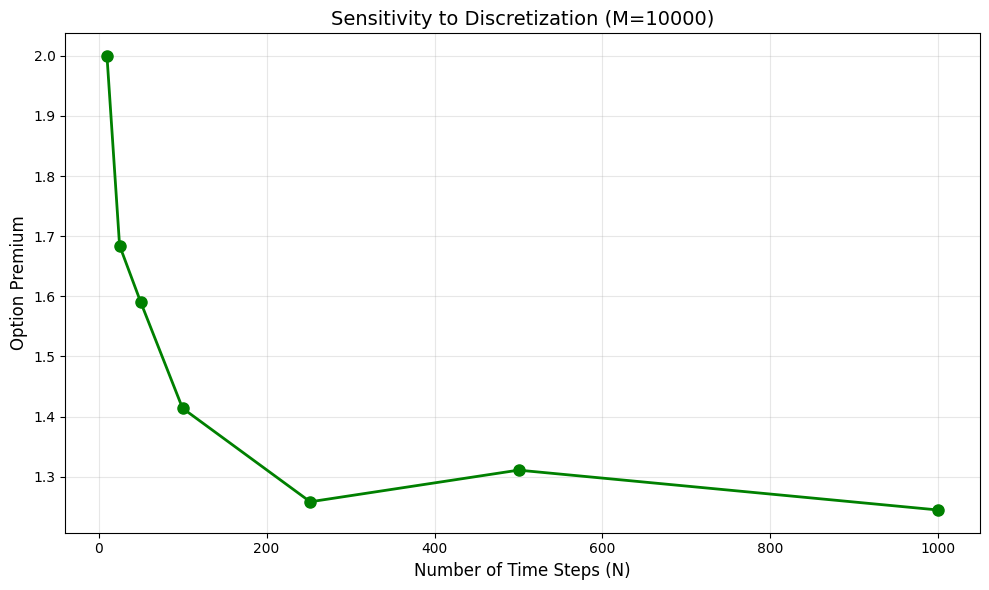


ANALYSIS COMPLETE


In [20]:
if __name__ == "__main__":
    analysis_results = run_comprehensive_analysis()